In [50]:
import pandas as pd
import re
import nltk
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import folium
import warnings
warnings.filterwarnings('ignore')
import os
import math

In [6]:
test = pd.read_csv('Crimes_-_2001_to_present.csv')
test.head()

ID Case Number                    Date                   Block  IUCR  \
0  5227348    HN109638  01/06/2007 11:10:00 AM  092XX S UNIVERSITY AVE  1811   
1  5227349    HN108643  12/30/2006 05:30:00 PM    024XX S TRUMBULL AVE  0610   
2  5227350    HN108625  01/05/2007 07:00:00 PM    110XX S MICHIGAN AVE  0860   
3  5227351    HN106850  01/04/2007 08:36:01 PM       066XX S LAFLIN ST  0560   
4  5227353    HN109262  01/06/2007 02:38:00 AM         037XX N TROY ST  1320   

      Primary Type                   Description     Location Description  \
0        NARCOTICS  POSS: CANNABIS 30GMS OR LESS                 SIDEWALK   
1         BURGLARY                FORCIBLE ENTRY                APARTMENT   
2            THEFT                  RETAIL THEFT       SMALL RETAIL STORE   
3          ASSAULT                        SIMPLE  RESIDENCE PORCH/HALLWAY   
4  CRIMINAL DAMAGE                    TO VEHICLE                   STREET   

  Arrest Domestic              ...                Ward  Community Area  \
0   True    False              ...                 8.0            47.0   
1  False    False              ...                22.0            30.0   
2  False    False              ...                 9.0            49.0   
3   True    False              ...                17.0            67.0   
4  False    False              ...                33.0            16.0   

   FBI Code  X Coordinate Y Coordinate  Year              Updated On  \
0        18     1185491.0    1843956.0  2007  04/15/2016 08:55:02 AM   
1        05     1153757.0    1887491.0  2006  04/15/2016 08:55:02 AM   
2        06     1178803.0    1831679.0  2007  04/15/2016 08:55:02 AM   
3       08A     1167477.0    1860796.0  2007  04/15/2016 08:55:02 AM   
4        14     1154720.0    1924748.0  2007  04/15/2016 08:55:02 AM   

    Latitude  Longitude                       Location  
0  41.726957 -87.596113  (41.726956515, -87.596112561)  
1  41.847110 -87.711205   (41.847110034, -87.71120488)  
2  41.693421 -87.620983  (41.693421344, -87.620983384)  
3  41.773572 -87.661618  (41.773572236, -87.661618385)  
4  41.949328 -87.706672  (41.949327507, -87.706671912)  

[5 rows x 22 columns]

In [7]:
del test['Location']
del test['Y Coordinate']
del test['X Coordinate']
test.head()

ID Case Number                    Date                   Block  IUCR  \
0  5227348    HN109638  01/06/2007 11:10:00 AM  092XX S UNIVERSITY AVE  1811   
1  5227349    HN108643  12/30/2006 05:30:00 PM    024XX S TRUMBULL AVE  0610   
2  5227350    HN108625  01/05/2007 07:00:00 PM    110XX S MICHIGAN AVE  0860   
3  5227351    HN106850  01/04/2007 08:36:01 PM       066XX S LAFLIN ST  0560   
4  5227353    HN109262  01/06/2007 02:38:00 AM         037XX N TROY ST  1320   

      Primary Type                   Description     Location Description  \
0        NARCOTICS  POSS: CANNABIS 30GMS OR LESS                 SIDEWALK   
1         BURGLARY                FORCIBLE ENTRY                APARTMENT   
2            THEFT                  RETAIL THEFT       SMALL RETAIL STORE   
3          ASSAULT                        SIMPLE  RESIDENCE PORCH/HALLWAY   
4  CRIMINAL DAMAGE                    TO VEHICLE                   STREET   

  Arrest Domestic  Beat  District  Ward  Community Area FBI Code  Year  \
0   True    False   413       4.0   8.0            47.0       18  2007   
1  False    False  1024      10.0  22.0            30.0       05  2006   
2  False    False   513       5.0   9.0            49.0       06  2007   
3   True    False   725       7.0  17.0            67.0      08A  2007   
4  False    False  1733      17.0  33.0            16.0       14  2007   

               Updated On   Latitude  Longitude  
0  04/15/2016 08:55:02 AM  41.726957 -87.596113  
1  04/15/2016 08:55:02 AM  41.847110 -87.711205  
2  04/15/2016 08:55:02 AM  41.693421 -87.620983  
3  04/15/2016 08:55:02 AM  41.773572 -87.661618  
4  04/15/2016 08:55:02 AM  41.949328 -87.706672

In [8]:
test.isnull().sum(0)

ID                           0
Case Number                  4
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      2229
Arrest                       0
Domestic                     0
Beat                         0
District                    49
Ward                    614859
Community Area          616040
FBI Code                     0
Year                         0
Updated On                   0
Latitude                 76399
Longitude                76399
dtype: int64

In [9]:
test2 = test[test.isnull().sum(1)==0]
print len(test), len(test2)

6305351 5620527


In [10]:
ym = test2['Latitude'].mean()
xm = test2['Longitude'].mean()
Xrange = 0.3
Yrange = 0.3
xl = -88#xm-Xrange
xr = -87.5#xm+Xrange
yu = 42.05#ym+Yrange
yb = 41.62#ym-Yrange
logic = (test['Latitude']>yb) & (test['Latitude']<yu) & (test2['Longitude']<xr) & (test2['Longitude']>xl)
test2 = test2[logic]
len(test2)

5620354

176


(-0.5, 1199.5, 599.5, -0.5)

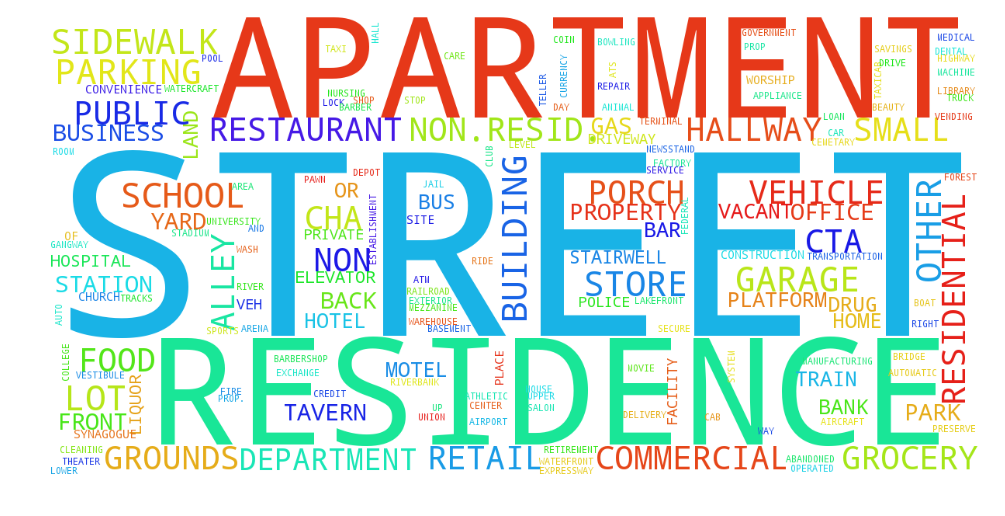

In [8]:
modelWd = test2#[haveModel["Content"].str.contains('([a-zA-Z]+\d{2,3}[a-zA-Z]+)|((?i)(zenfone)(?x)\w+)')]
myhash = {}
text = []


for sentence in modelWd["Location Description"]:
    seglist = re.split('[^\w\'\.]+',sentence)
    for item in seglist:
        if re.match('[\w\'\.]+',item):
            myhash[item.upper()] = myhash.get(item.upper(),0) + 1
            
model = pd.DataFrame(myhash.items(), columns=['model', 'number'])
model = model[model['number']>=4]
print len(model)

frequencies = []
for key, value in myhash.iteritems():
    frequencies.append((unicode(key),value))
#im = np.array(Image.open("asus-zefone-2.jpg"))
#wordcloud = WordCloud(background_color="white",font_path='simsun.ttc',mask=im).fit_words(frequencies)
wordcloud = WordCloud(background_color="white",scale = 3).fit_words(frequencies)

#image_colors = ImageColorGenerator(im)

plt.figure(figsize=(12, 9))
#plt.imshow(wordcloud.recolor(color_func=image_colors))
plt.imshow(wordcloud)
plt.axis("off")

In [9]:
temp = model.sort_values(by = 'number', ascending=False).head(10).reset_index()[['model', 'number']]
temp#.loc[8][0]

model   number
0     STREET  1470622
1  RESIDENCE  1140101
2  APARTMENT   624305
3   SIDEWALK   587451
4      STORE   295165
5     GARAGE   279381
6        LOT   237507
7      OTHER   223253
8    PARKING   216631
9   BUILDING   176061

In [3]:
test2['Primary Type'].value_counts()

NameError: name 'test2' is not defined

In [56]:
def classWC(crimeClass,i):
    modelWd = test2[test2["Primary Type"] == crimeClass]
    myhash = {}
    text = []

    for sentence in modelWd["Description"]:
        seglist = re.split('[^\w\'\.]+',sentence)
        for item in seglist:
            if re.match('[\w\'\.]+',item):
                myhash[item.upper()] = myhash.get(item.upper(),0) + 1
            
    model = pd.DataFrame(myhash.items(), columns=['model', 'number'])
    #model = model[model['number']>=4]
    #print len(model)

    frequencies = []
    for key, value in myhash.iteritems():
        frequencies.append((unicode(key),value))

    wordcloud = WordCloud(background_color="white",scale = 3).fit_words(frequencies)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(str(i)+'.'+crimeClass.lower()+'('+str(len(model))+' words)')
    plt.savefig(u'圖2/'+crimeClass+'.png')

In [12]:
test2['Primary Type'].value_counts().index

Index([u'THEFT', u'BATTERY', u'CRIMINAL DAMAGE', u'NARCOTICS', u'ASSAULT',
       u'OTHER OFFENSE', u'BURGLARY', u'MOTOR VEHICLE THEFT', u'ROBBERY',
       u'DECEPTIVE PRACTICE', u'CRIMINAL TRESPASS', u'PROSTITUTION',
       u'WEAPONS VIOLATION', u'PUBLIC PEACE VIOLATION',
       u'OFFENSE INVOLVING CHILDREN', u'CRIM SEXUAL ASSAULT', u'SEX OFFENSE',
       u'GAMBLING', u'INTERFERENCE WITH PUBLIC OFFICER',
       u'LIQUOR LAW VIOLATION', u'ARSON', u'HOMICIDE', u'KIDNAPPING',
       u'INTIMIDATION', u'STALKING', u'OBSCENITY', u'PUBLIC INDECENCY',
       u'OTHER NARCOTIC VIOLATION', u'CONCEALED CARRY LICENSE VIOLATION',
       u'NON-CRIMINAL', u'NON - CRIMINAL', u'HUMAN TRAFFICKING', u'RITUALISM',
       u'NON-CRIMINAL (SUBJECT SPECIFIED)'],
      dtype='object')

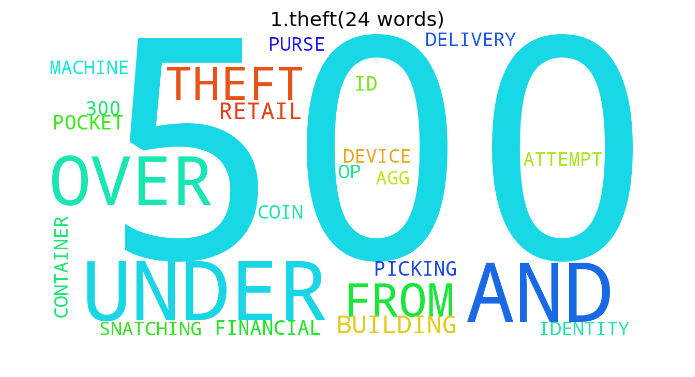

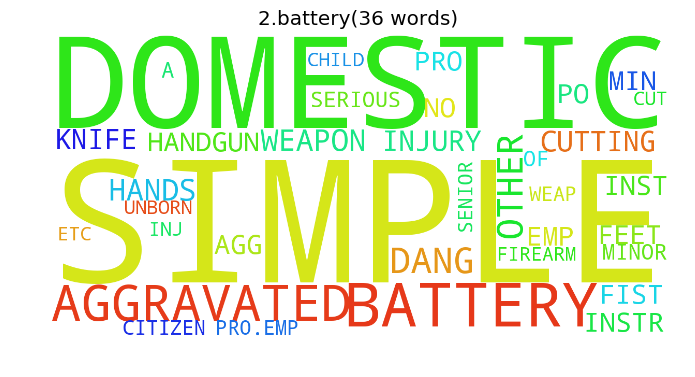

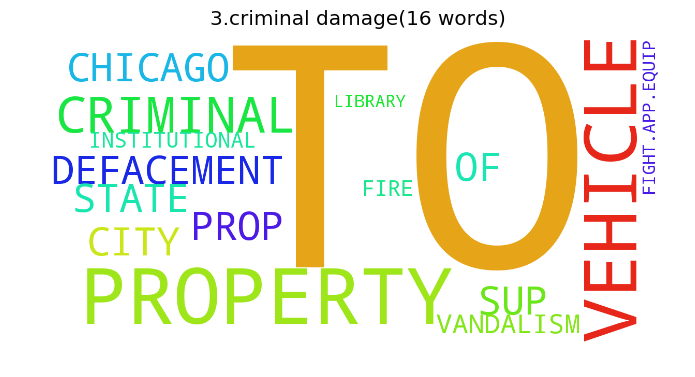

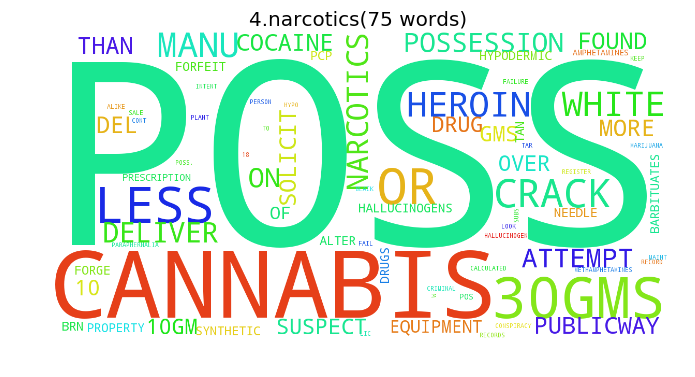

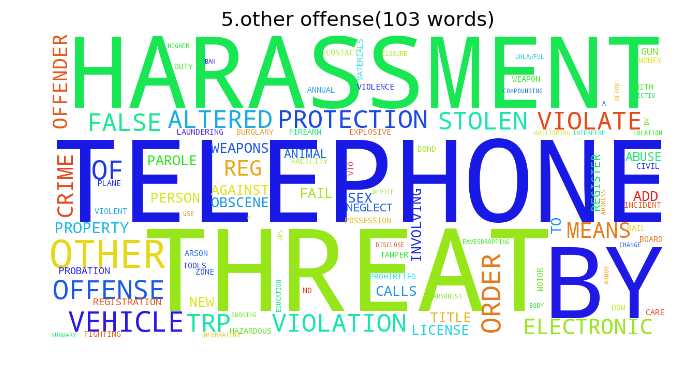

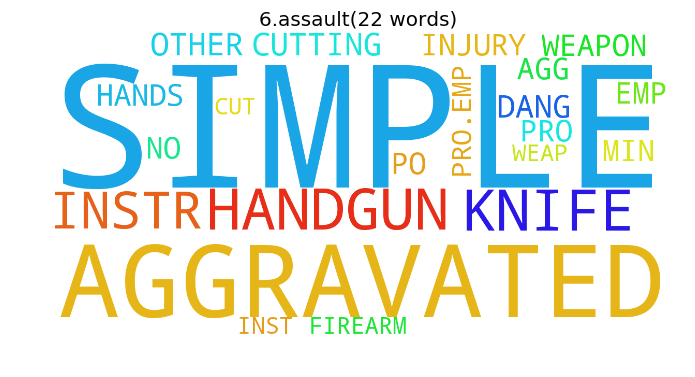

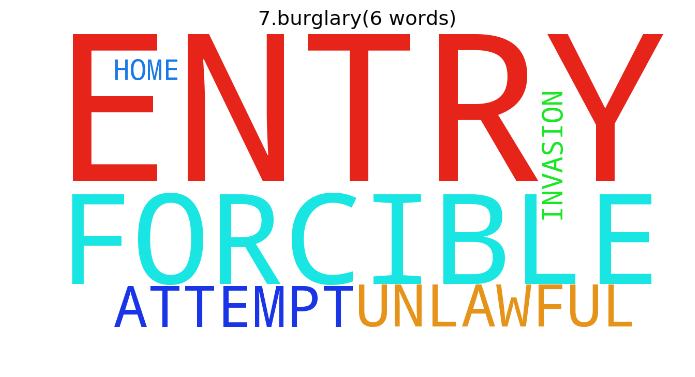

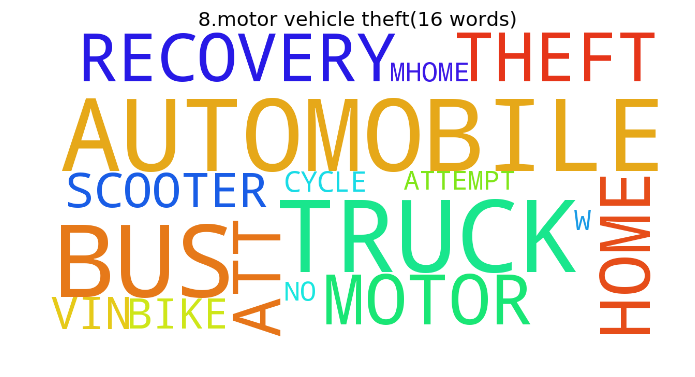

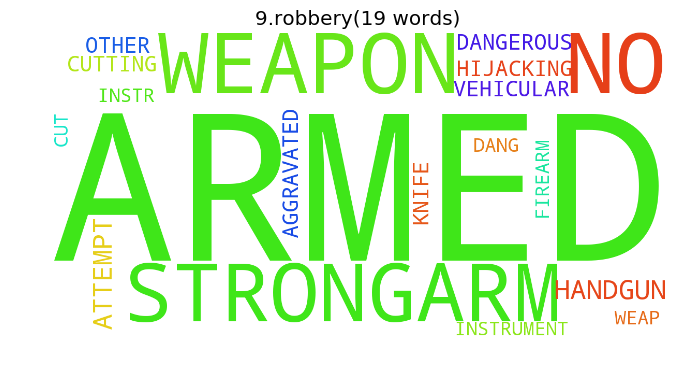

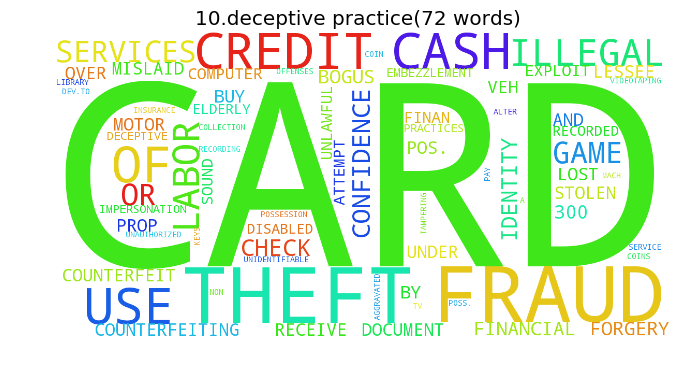

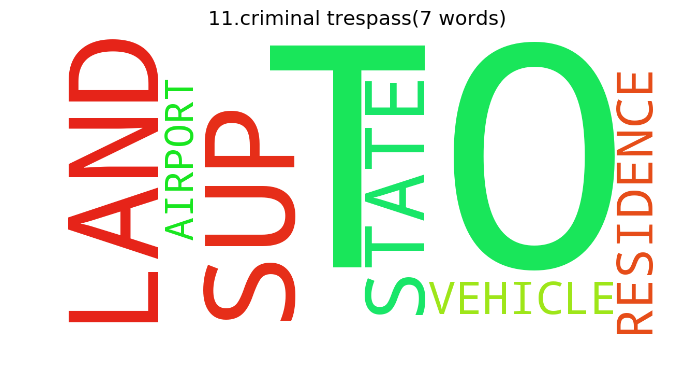

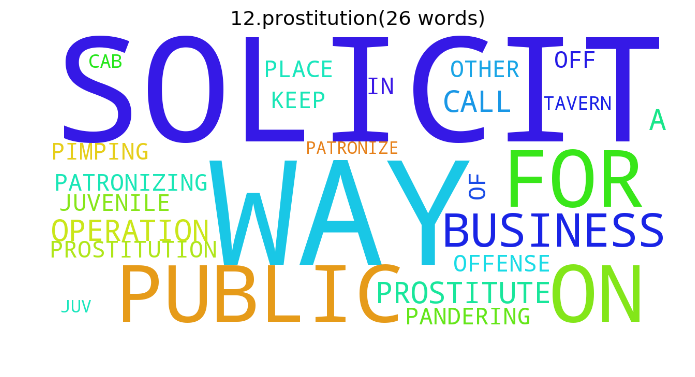

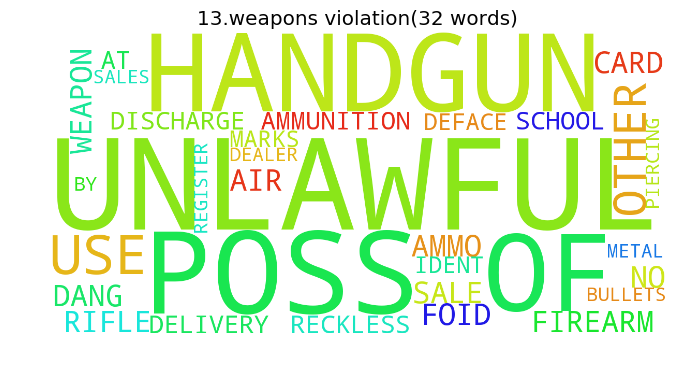

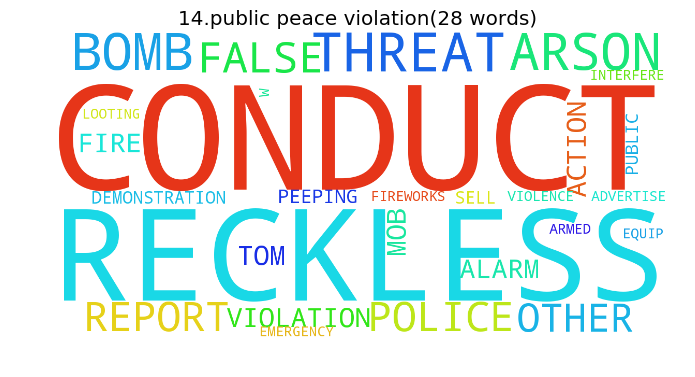

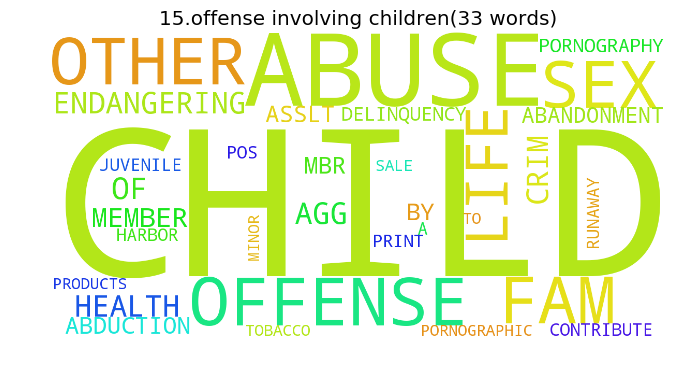

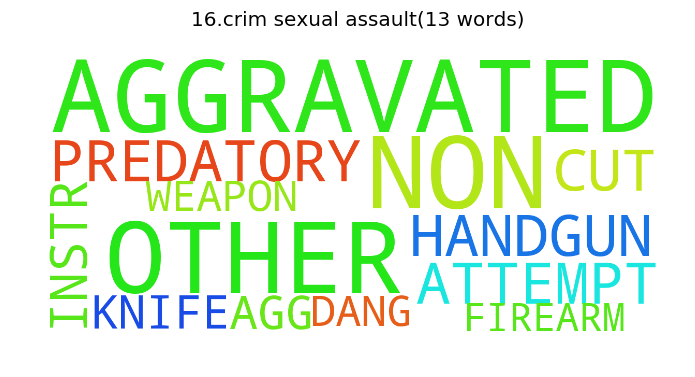

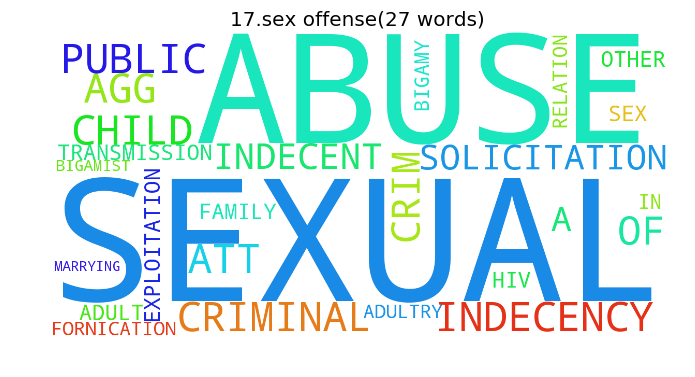

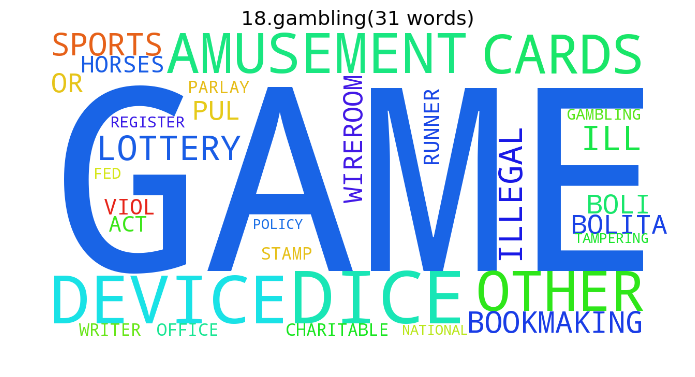

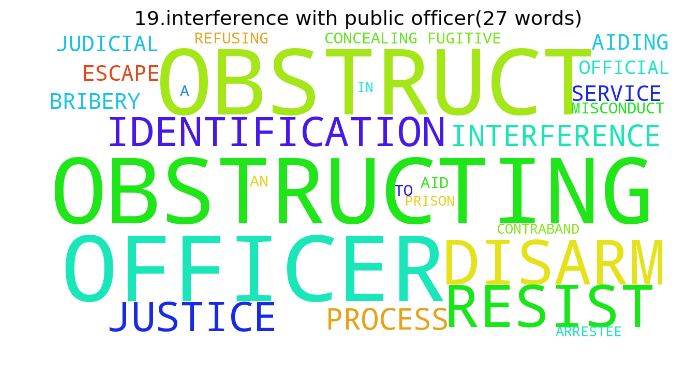

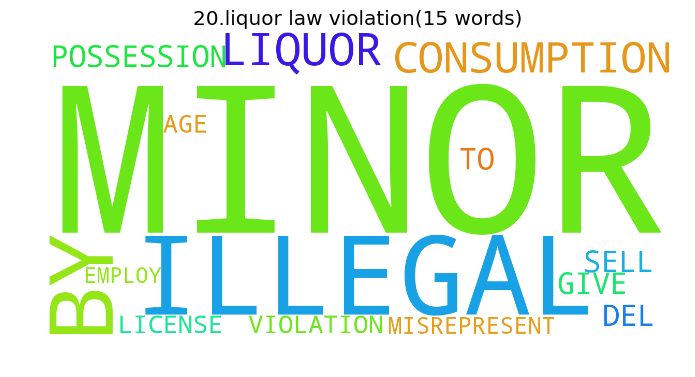

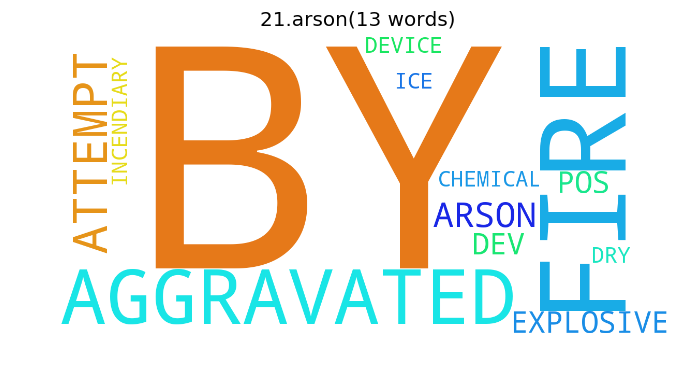

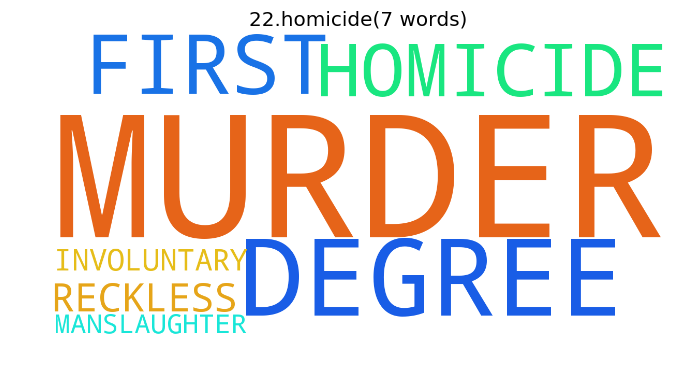

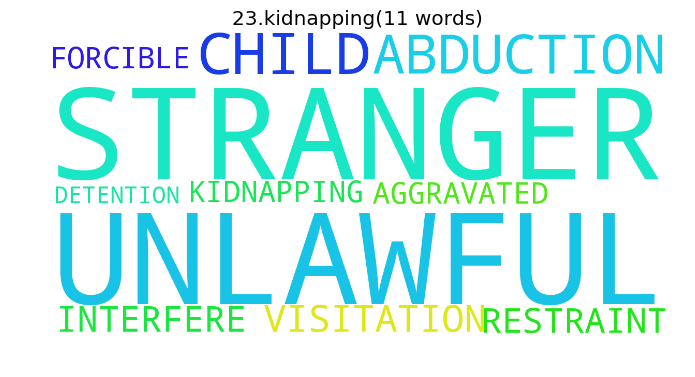

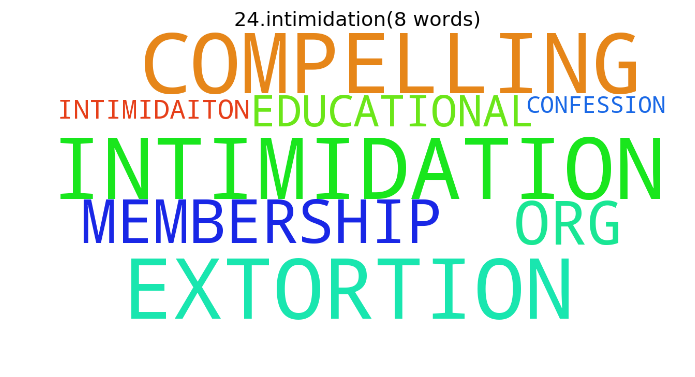

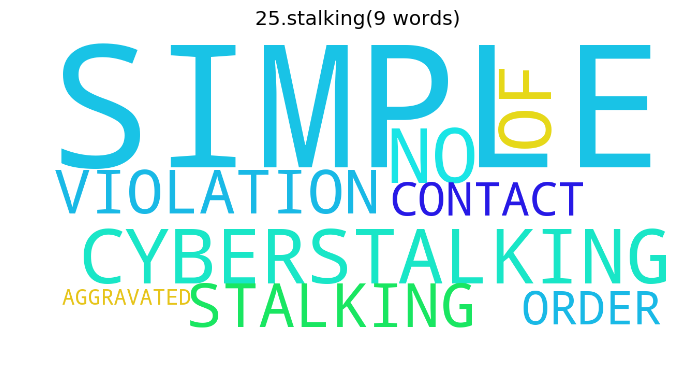

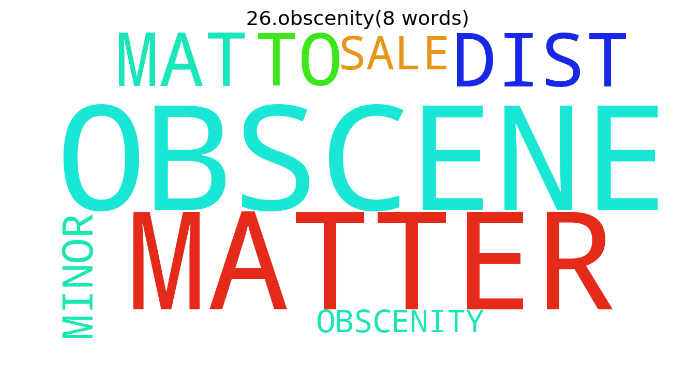

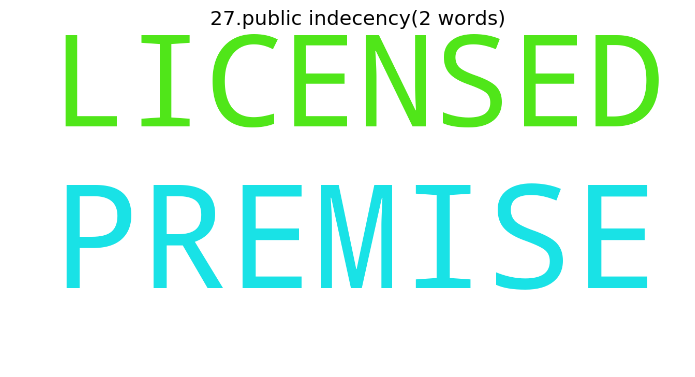

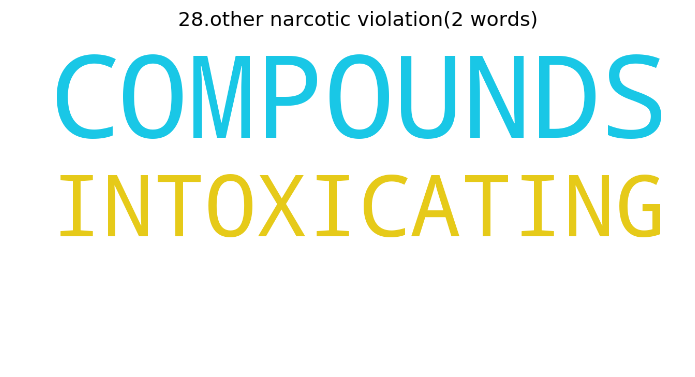

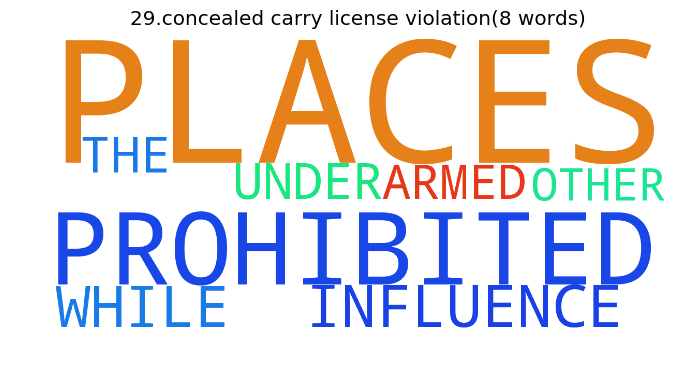

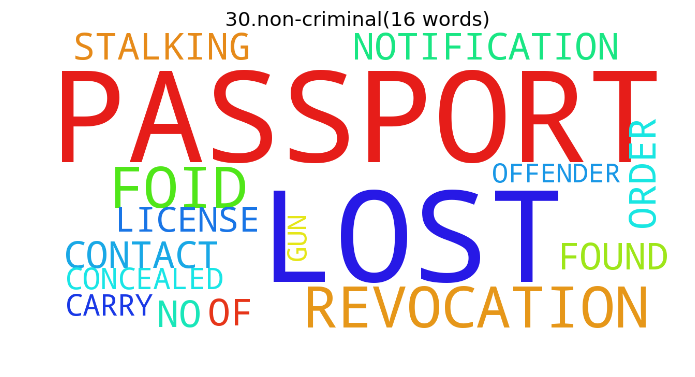

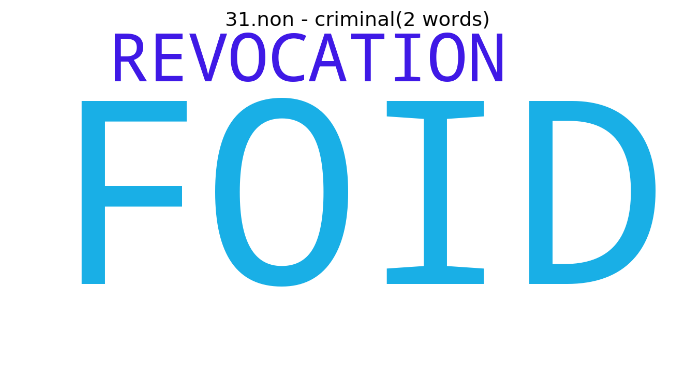

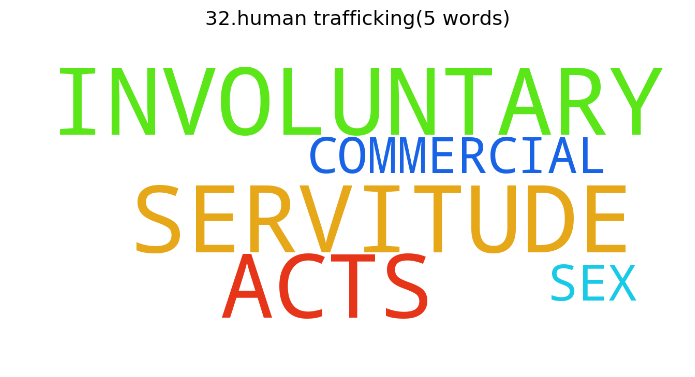

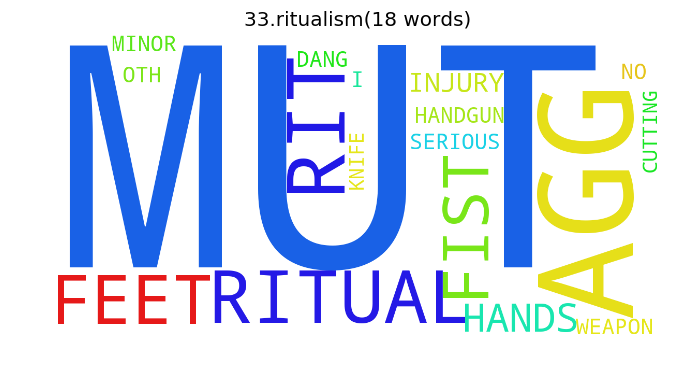

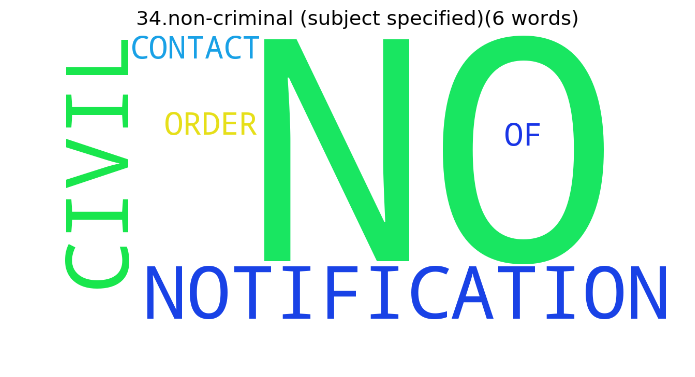

In [57]:
i = 1
for name in test2['Primary Type'].value_counts().index:
    classWC(name,i)
    i=i+1

In [14]:
len(test2['Primary Type'].value_counts().index)

34

In [15]:
len(test2['Primary Type'].value_counts().index)%6

4

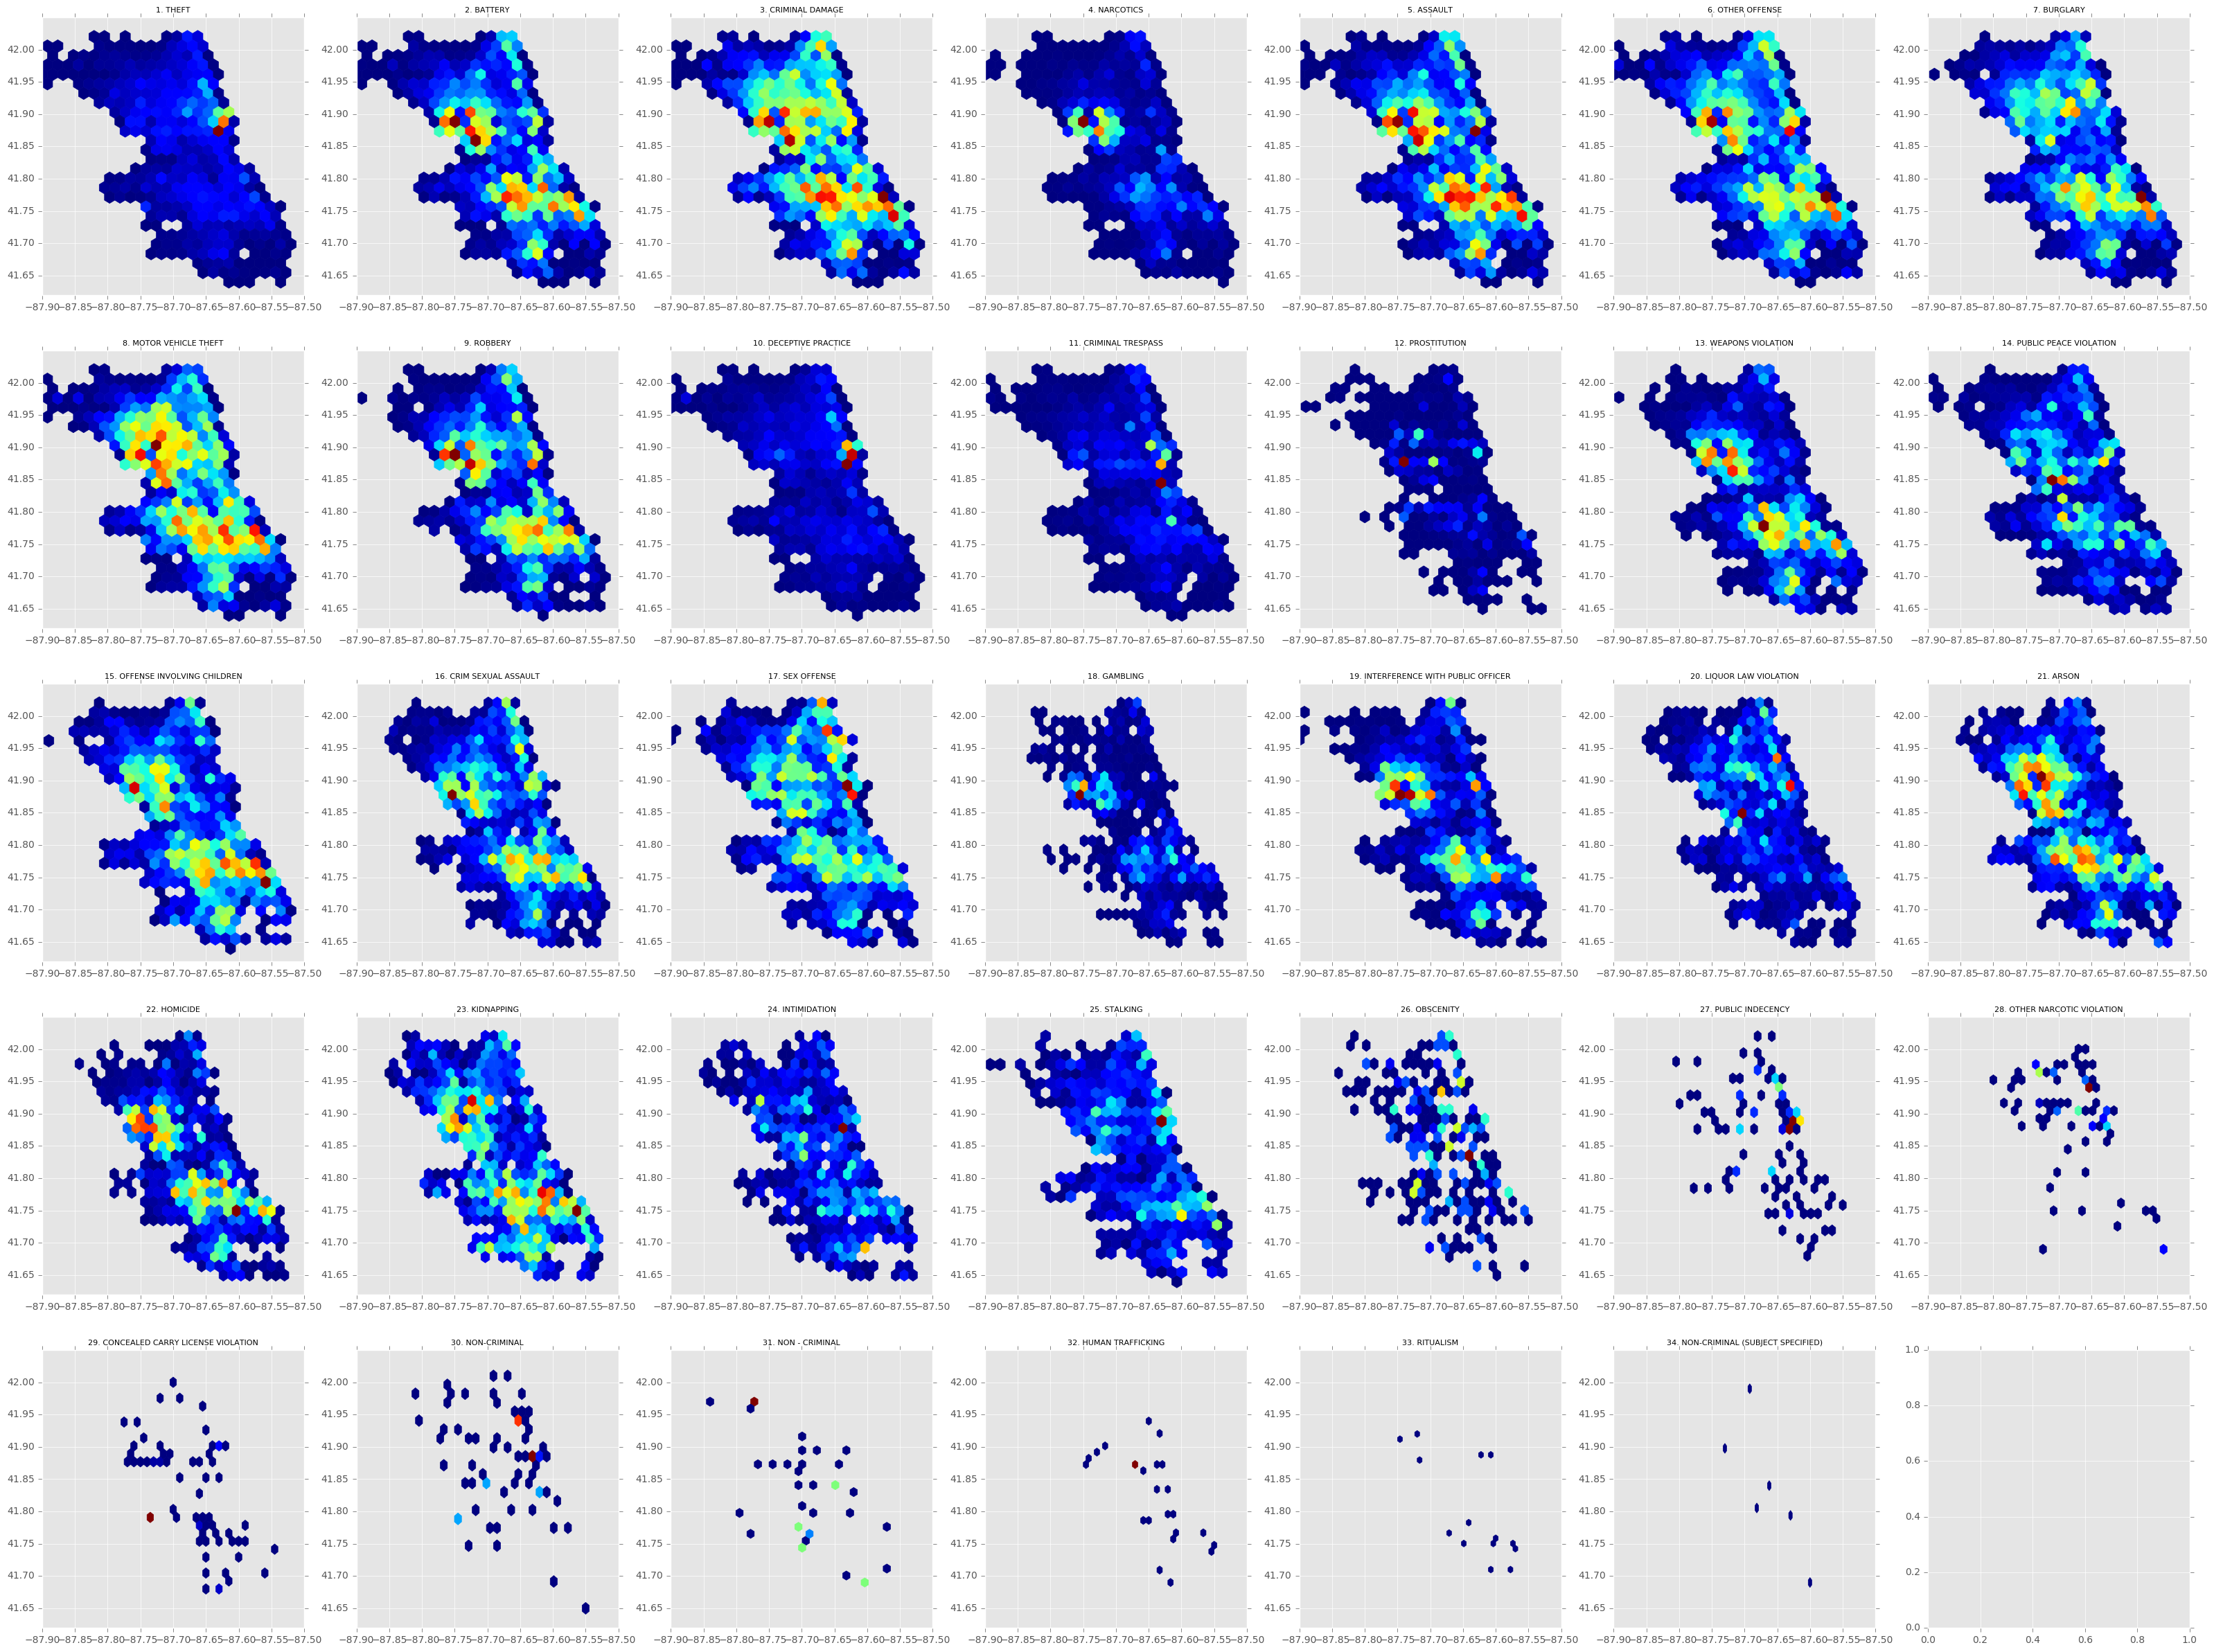

In [16]:
plt.subplots_adjust(wspace = 30)
Row = 5
Col = 7
RN = 100
fig, axes = plt.subplots(nrows=Row, ncols=Col, figsize=(40, 30))#, dpi=60)
for i in range(len(test2['Primary Type'].value_counts().index)):
    cs = test2['Primary Type'].value_counts().index[i]
    Data = test2[test['Primary Type'] == cs]
    Data2 = (Data[['Longitude','Latitude','Arrest']]*RN).round().astype(int)
    Data2 = pd.DataFrame(Data2.groupby(
                        ['Longitude','Latitude']).count()['Arrest']
                       ).reset_index().rename(columns={'Arrest':'count'})
    Data2[['Longitude','Latitude']] = Data2[['Longitude','Latitude']]/RN
    axes[i/Col,i%Col].hexbin(Data2['Longitude'],Data2['Latitude'],Data2['count'],24)
    axes[i/Col,i%Col].set_title(str(i+1)+'. '+cs, fontsize=8)
    axes[i/Col,i%Col].set_xlim([xl,xr])
    axes[i/Col,i%Col].set_ylim([yb,yu])

In [54]:
RN = 100
colormap = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
            '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928',
            '#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
            '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']
j = 0
airports_map = folium.Map(location=[test2['Latitude'].mean(), test2['Longitude'].mean()], zoom_start=10)
for crimeClass in test2['Primary Type'].value_counts().index:
    test3 = (test2[['Longitude','Latitude','Arrest']]*RN).round().astype(int)
    test3 = test3[test2['Primary Type'] == crimeClass]
    test3 = pd.DataFrame(test3.groupby(
                                        ['Longitude','Latitude']
                                      ).count()['Arrest']
                        ).reset_index().rename(columns={'Arrest':'count'})
    test3[['Longitude','Latitude']] = test3[['Longitude','Latitude']]/RN
    #print len(test3)
    if len(test3) < 500:
        continue
    test3 = test3.sort_values(by='count',ascending=False).reset_index()
    test4 = test4.reset_index()
    test4 = test3.loc[0:2]
    #print len(test4)

    # Draw markers on the map.
    for i in range(len(test4)):
        folium.RegularPolygonMarker(fill_color = colormap[j],
                                    radius = math.log(test4['count'][i])*2,
                                    location = [test4["Latitude"][i]+j*0.0005,
                                              test4["Longitude"][i]+j*0.00041],
                                    popup = crimeClass+': '+str(test4['count'][i]),
                                   ).add_to(airports_map)
    j = j+1
# Create and show the map.

airports_map.save('top crime.html')
airports_map

In [55]:
airports_map.save('top crime.html')

In [39]:
test3.loc[0:3]

Longitude  Latitude  count
0     -87.73     41.90      1
1     -87.69     41.99      1
2     -87.68     41.80      1
3     -87.66     41.84      1

In [ ]:
test3 = (test2[['Longitude','Latitude','Arrest']])
test3 = test3[test2['Primary Type'] == test2['Primary Type'].value_counts().index[19]]

print len(test3)
test4 = test3
test4 = test4.reset_index()
print len(test4)
airports_map = folium.Map(location=[test2['Latitude'].mean(), test2['Longitude'].mean()], zoom_start=10)


locations = list(zip(test4['Latitude'],test4['Longitude']))
popups = ['{}'.format(loc) for loc in locations]

from folium.plugins import MarkerCluster

airports_map.add_child(MarkerCluster(locations=locations, popups=popups))

airports_map.save('MCtest.html')

airports_map

11546
11546


In [25]:
len(locations)

58649

In [41]:
import os
import time
from selenium import webdriver

delay=3
fn='testmap.png'
tmpurl='file:\\\\{path}\\{mapfile}'.format(path=os.getcwd(),mapfile=fn)
airports_map.save(fn)

tmpurl

'file:\\\\D:\\wayne\\Sheepbox\\DataSet\\BD_crimeData\\testmap.png'

In [1]:
import imgkit

imgkit.from_url('http://google.com', 'out.jpg')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [17]:
m = folium.Map(location=[44, -73], zoom_start=5)

marker_cluster = folium.MarkerCluster().add_to(m)


folium.Marker(
    location=[40.67, -73.94],
    popup='Add popup text here.',
    icon=folium.Icon(color='green', icon='ok-sign'),
).add_to(marker_cluster)

folium.Marker(
    location=[44.67, -73.94],
    popup='Add popup text here.',
    icon=folium.Icon(color='red', icon='remove-sign'),
).add_to(marker_cluster)

folium.Marker(
    location=[44.67, -71.94],
    popup='Add popup text here.',
    icon=None,
).add_to(marker_cluster)

m.save(os.path.join('MarkerCluster_simple.html'))

m

In [26]:
import numpy as np

size = 1000
lons = np.random.randint(-180, 180, size=size)
lats = np.random.randint(-90, 90, size=size)

locations = list(zip(lats, lons))
popups = ['{}'.format(loc) for loc in locations]

from folium.plugins import MarkerCluster

m = folium.Map(location=[np.mean(lats), np.mean(lons)],
                  tiles='Cartodb Positron', zoom_start=1)

m.add_child(MarkerCluster(locations=locations, popups=popups))

m.save(os.path.join('1000_MarkerCluster.html'))

m